# Volumetric data processing
This is a simple demo on toy 3d data for source extraction and deconvolution using CaImAn.
For more information check demo_pipeline.ipynb which performs the complete pipeline for
2d two photon imaging data.

In [1]:
from IPython import get_ipython
import logging
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
import glob
import pickle
import sys
from scipy.ndimage import gaussian_filter
from tifffile.tifffile import imwrite

import caiman as cm
from caiman.utils.visualization import nb_view_patches3d
import caiman.source_extraction.cnmf as cnmf

try:
    if __IPYTHON__:
        get_ipython().run_line_magic('load_ext', 'autoreload')
        get_ipython().run_line_magic('autoreload', '2')
except NameError:
    pass

import bokeh.plotting as bpl
bpl.output_notebook()

logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.WARNING)

from bokeh.io import output_notebook 
output_notebook()

import plotly.graph_objects as go
import plotly.express as px


import caiman_assess_segs_functions as fn

/tmp/ipykernel_57813/1572238236.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-06-06 10:44:24.128761: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-06 10:44:24.128890: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-06 10:44:24.436570: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable 

Loading BokehJS ...

Loading BokehJS ...

In [2]:
sys.path.insert(0, '../')
from experiment_info import samples, data_dir, puffs, params
import skimage as ski


# Load CaImAn results

In [3]:
# specify number of segments
K = 10
results_dir = f'results/caiman/K{K}'
def load_C_A_matrices(results_dir, samples):
    # A matrix specifies the positions of components
    # C matrix specifies the activity of components
    A_mats = []
    C_mats = []
    for i,samp in enumerate(samples):

        try:
            with open(f'{results_dir}/{samp}_cnm2.pkl', 'rb') as f:
                cnm = pickle.load(f)
        except FileNotFoundError:
            print(f'No file found for sample {samp}')
            continue

        A = cnm.estimates.A.toarray()
        C = cnm.estimates.C

        A_mats.append(A)
        C_mats.append(C)
    return A_mats, C_mats

A_mats, C_mats = load_C_A_matrices(results_dir, samples)
print(f'Loaded {len(A_mats)} samples')
print(C_mats[0].shape)
print(A_mats[0].shape)




Loaded 15 samples
(9, 4032)
(393216, 9)


## Split CaImAn results by subspecies

In [4]:
def split_list_by_subspecies(l):
    ORL = l[0:5]
    U52 = l[5:10]
    FCV = l[10:16]
    return ORL, U52, FCV

A_ORL_mats, A_U52_mats, A_FCV_mats = split_list_by_subspecies(A_mats)
C_ORL_mats, C_U52_mats, C_FCV_mats = split_list_by_subspecies(C_mats)
ORL_names, U52_names, FCV_names = split_list_by_subspecies(samples)

print(len(C_ORL_mats), len(C_U52_mats), len(C_FCV_mats))

5 5 5


## Plot activity traces

In [5]:
def make_plot_by_subspecies(C_mats, A_mats, samp_names, odor_names, positions):
    fig, axs = plt.subplots(1,5,figsize=(35, 6))
    for samp,(C,A) in enumerate(zip(C_mats, A_mats)):
        for seg in range(C.shape[0]):
            seg_indices = np.nonzero(A[:,seg])
            trace_mean_recontructed = np.array([np.mean(A[:,seg][seg_indices]) * C[seg,i] for i in range(C.shape[1])])
            # print(np.max(trace_mean_recontructed))
            # plot the trace directly from C matrix
            # axs[samp].plot(C[seg,:] + seg*2, c='black')  # Offset each trace by i*3
            # plot the trace from A and C matrix
            axs[samp].plot(trace_mean_recontructed + seg*0.02, c='black')
        axs[samp].set_yticks([])
        axs[samp].set_title(samp_names[samp])
        axs[samp].set_xticks(positions, odor_names, rotation=90)
        # add grid line
        axs[samp].grid(axis='x', alpha=0.2)

odor_names = []
positions = []
for i,puff in enumerate(puffs):
    if puff.trial == 1:
        odor_names.append(puff.odor_name)
        positions.append(i*params['n_frames_to_analyze'] + params['n_frames_to_analyze']/2)
    

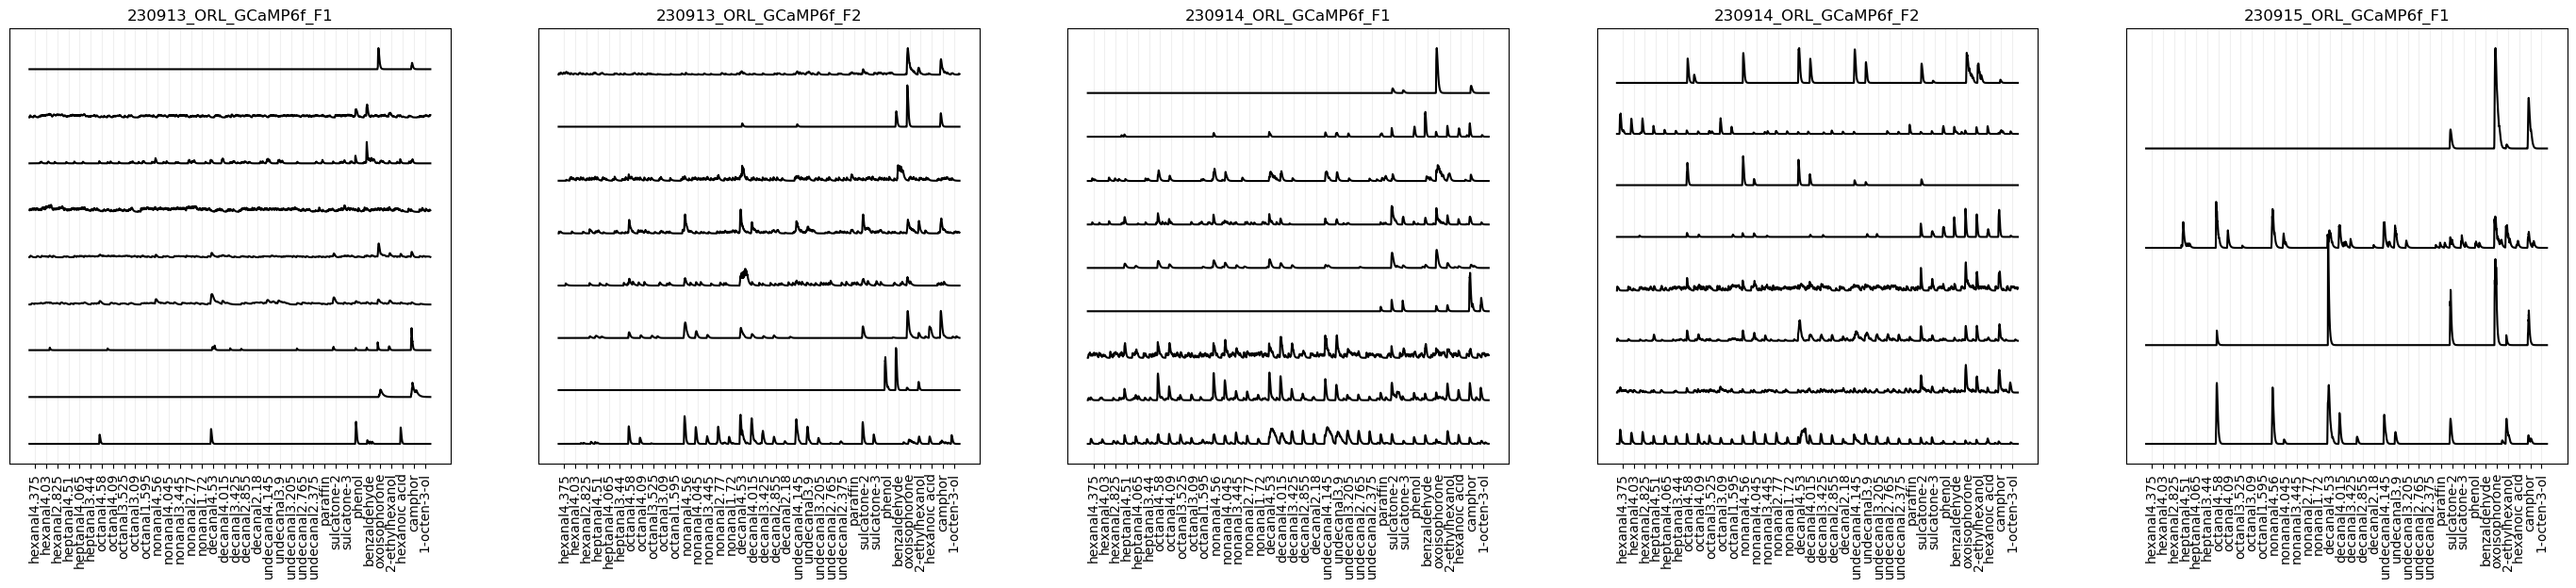

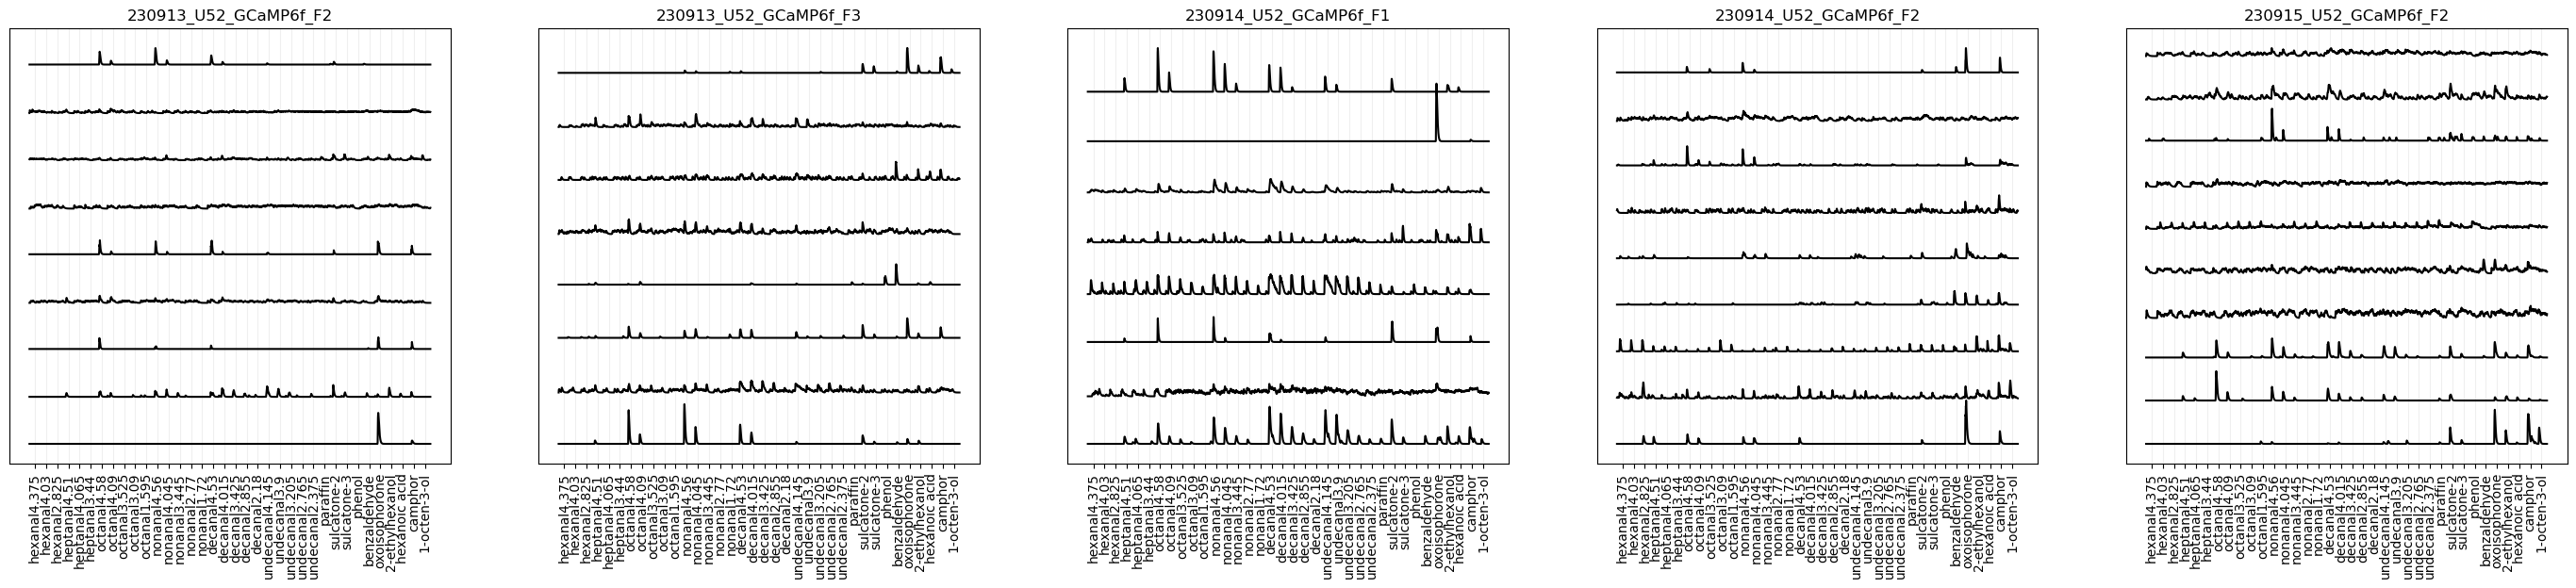

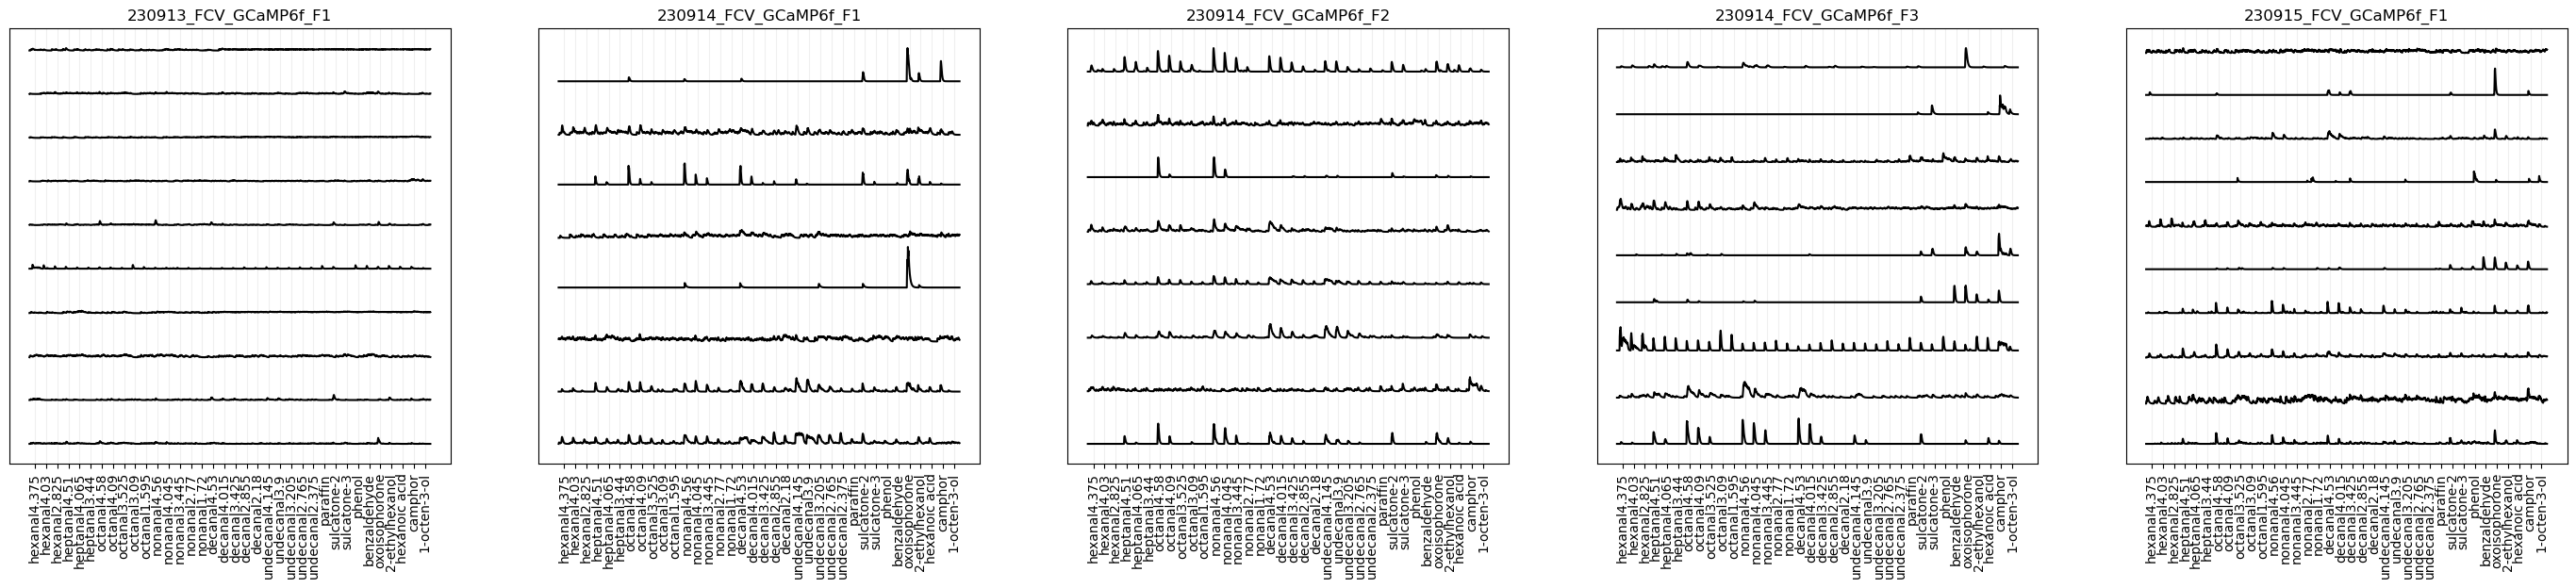

In [6]:
make_plot_by_subspecies(C_ORL_mats, A_ORL_mats, ORL_names, odor_names, positions)
make_plot_by_subspecies(C_U52_mats, A_U52_mats, U52_names, odor_names, positions)
make_plot_by_subspecies(C_FCV_mats, A_FCV_mats, FCV_names, odor_names, positions)

# Compute correlations between segments

In [18]:

def compute_corrs_and_intersections(C_mats, A_mats, names):
    within_samp_seg_corrs = {} # a dictionary of segment-wise correlations, i.e. for each segment, the correlation with all other segments
    intersection_fractions = {} # a dictionary of segment-wise intersection fractions, i.e. for each segment, the fraction of pixels that overlap with all other segments

    for i,samp in enumerate(names):
        corr_mat = fn.calculate_pairwise_temporal_corrs(C_mats[i], C_mats[i])
        # This is the full correlation matrix
        # for each row in corr_mat, get the off-diagonal elements
        # Row indices
        rows = np.arange(corr_mat.shape[0])
        # reshape matrix to not have diagonal elements
        non_diagonal_elements = [corr_mat[j, rows != j] for j in range(corr_mat.shape[0])]
        # take transpose so that columns correpond to total number of segments, and rows are 1 fewer than this number (b/c diagonal removed)
        within_samp_seg_corrs[samp] = np.array(non_diagonal_elements).T

        # repeat for calculating overlaps between segments
        intersection_fractions[samp] = fn.calculate_intersections_per_seg(A_mats[i], params['z_dim'], params['x_dim'], params['y_dim'])

    return within_samp_seg_corrs, intersection_fractions

within_samp_seg_corrs, intersection_fractions = compute_corrs_and_intersections(C_ORL_mats, A_ORL_mats, ORL_names)
# within_samp_seg_corrs, intersection_fractions = compute_corrs_and_intersections(C_U52_mats, A_U52_mats, U52_names)    
# within_samp_seg_corrs, intersection_fractions = compute_corrs_and_intersections(C_FCV_mats, A_FCV_mats, FCV_names)        

/jukebox/mcbride/bjarnold/miniforge3/envs/caiman/lib/python3.11/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.25'` for same effect.
  warnings.warn(msg, FutureWarning)
/jukebox/mcbride/bjarnold/miniforge3/envs/caiman/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/jukebox/mcbride/bjarnold/miniforge3/envs/caiman/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/jukebox/mcbride/bjarnold/miniforge3/envs/caiman/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: Futu

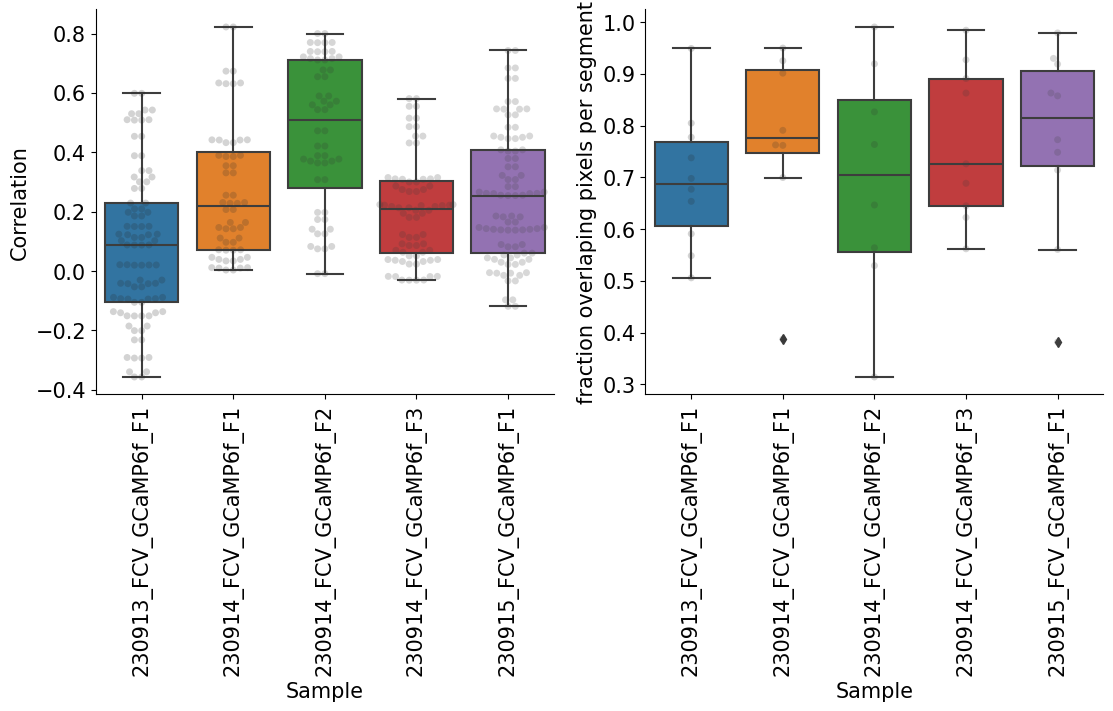

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(13, 5))
aggregated_corrs = {}
for i,s in enumerate(within_samp_seg_corrs):
    # get all pairwise segment correlations within sample
    aggregated_corrs[s]= within_samp_seg_corrs[s].flatten()
    # assert len(aggregated_corrs[s]) == (C_mats[0].shape[0] * (C_mats[0].shape[0] - 1)), "incorrect number of observations"
# Convert each list to a Series and create the DataFrame, using series naturally accounts for missing data (some samples have fewer segments, making diff number of rows per column)
corr_df = pd.DataFrame({k: pd.Series(v) for k, v in aggregated_corrs.items()})
# corr_df = pd.DataFrame.from_dict(aggregated_corrs)
intersection_df = pd.DataFrame({k: pd.Series(v) for k, v in intersection_fractions.items()})

# make a catplot of df showing box plot and the raw observations
sns.boxplot(data=corr_df, ax=axs[0])
sns.swarmplot(data=corr_df, color=".25", alpha=0.2, ax=axs[0])
axs[0].set_xlabel('Sample', fontsize=15)
axs[0].set_ylabel('Correlation', fontsize=15)
# rotate x labels
axs[0].tick_params(axis='x', rotation=90)

sns.boxplot(data=intersection_df, ax=axs[1])
sns.swarmplot(data=intersection_df, color=".25", alpha=0.2, ax=axs[1])
axs[1].set_xlabel('Sample', fontsize=15)
axs[1].set_ylabel('fraction overlaping pixels per segment', fontsize=15)
axs[1].tick_params(axis='x', rotation=90)

# increase font size of x and y labels
axs[0].tick_params(axis='both', which='major', labelsize=15)
axs[1].tick_params(axis='both', which='major', labelsize=15)

sns.despine()

In [90]:
len(aggregated_corrs[0])

12

In [91]:
ORL_names

['230913_ORL_GCaMP6f_F1',
 '230913_ORL_GCaMP6f_F2',
 '230914_ORL_GCaMP6f_F1',
 '230914_ORL_GCaMP6f_F2',
 '230915_ORL_GCaMP6f_F1']

## Make 3D plot of glomeruli for specific individual
Assess how much segments span x,y,z axes

In [92]:
fig = go.Figure()

colors = px.colors.qualitative.Plotly
  
# make copy of array
X = np.copy(A_ORL_mats[3])

# Iterate over datasets, adding each to the figure
for i in range(X.shape[1]): # columns of X are segments

  
  X_tmp = X[:,i]
  thresh = np.quantile(X_tmp[X_tmp>0], 0.75)
  X_tmp[X_tmp < thresh] = 0

  X_tmp = np.reshape(X_tmp, (params['z_dim'], params['x_dim'], params['y_dim']))
  z, x, y = np.nonzero(X_tmp)

  # get coordinate of the element with the maximum value
  z_max, x_max, y_max = np.unravel_index(np.argmax(X_tmp, axis=None), X_tmp.shape)
  z_max, x_max, y_max = [z_max], [x_max], [y_max] # Convert to list to match the shape of the other arrays
  fig.add_trace(go.Scatter3d(x=x, y=y, z=z,
                              mode='markers',
                              marker=dict(size=6, opacity=0.01, color=colors[i]),
                              name=f'Set {i+1}'))  # Name each set for the legend
  fig.add_trace(go.Scatter3d(x=x_max, y=y_max, z=z_max,
                              mode='markers',
                              marker=dict(size=4, opacity=1, color='black'),
                              name=f'Set {i+1}'))  # Name each set for the legend

# Update layout with axis limits and title
fig.update_layout(scene=dict(
                    xaxis=dict(title='X Axis', range=[0, 128]),
                    yaxis=dict(title='Y Axis', range=[0, 128]),
                    zaxis=dict(title='Z Axis', range=[0, 24]),
                    aspectmode='manual',
                    aspectratio=dict(x=1, y=1, z=1)),  # Adjust z aspect ratio according to the z range),
                  title='Multiple 3D Coordinate Sets',
                  width=700,
                  margin=dict(r=20, b=10, l=10, t=10))

# Show the plot
fig.show()

In [93]:
colors = plt.get_cmap('tab10')  # 'tab10' is the default matplotlib colormap
colors = [colors(i/10) for i in range(10)]

colors



[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)]

In [94]:
def load_h5(filename):
    with h5py.File(filename, 'r') as file:
        dataset = file['data'] # Access the dataset containing the 3D matrix
        mat = np.array(dataset)
    return mat

samp = "230914_ORL_GCaMP6f_F2"
X_file = f'/jukebox/mcbride/bjarnold/new_analysis/data/Mar_22_2024/4_Glomeruli/{samp}/svd_k_20/cluster_power_8/segments_10/X.h5'
X_mat = load_h5(X_file)
fig = go.Figure()

# X = X_mat_ref
X = X_mat

for i in range(X.shape[1]): # columns of X are segments

  
  X_tmp = X[:,i]
  thresh = np.quantile(X_tmp[X_tmp>0], 0.0)
  X_tmp[X_tmp < thresh] = 0

  X_tmp = np.reshape(X_tmp, (params['z_dim'], params['x_dim'], params['y_dim']))
  z, x, y = np.nonzero(X_tmp)

  # get coordinate of the element with the maximum value
  z_max, x_max, y_max = np.unravel_index(np.argmax(X_tmp, axis=None), X_tmp.shape)
  z_max, x_max, y_max = [z_max], [x_max], [y_max] # Convert to list to match the shape of the other arrays
  fig.add_trace(go.Scatter3d(x=x, y=y, z=z,
                              mode='markers',
                              marker=dict(size=2, opacity=0.05),
                              name=f'Set {i+1}'))  # Name each set for the legend
  fig.add_trace(go.Scatter3d(x=x_max, y=y_max, z=z_max,
                              mode='markers',
                              marker=dict(size=4, opacity=1, color='black'),
                              name=f'Set {i+1}'))  # Name each set for the legend

# Update layout with axis limits and title
fig.update_layout(scene=dict(
                    xaxis=dict(title='X Axis', range=[0, 128]),
                    yaxis=dict(title='Y Axis', range=[0, 128]),
                    zaxis=dict(title='Z Axis', range=[0, 24]),
                    aspectmode='manual',
                    aspectratio=dict(x=1, y=1, z=0.33)),  # Adjust z aspect ratio according to the z range),
                  title='Multiple 3D Coordinate Sets',
                  width=700,
                  margin=dict(r=20, b=10, l=10, t=10))

# Show the plot
fig.show()

NameError: name 'h5py' is not defined

In [ ]:
X = A_ORL_mats[3]
C = C_ORL_mats[3]
X.shape

(393216, 8)

In [ ]:
seg_indices = [0,2,7]

X_seg = X[:,seg_indices]
X_seg.shape

(393216, 3)

In [ ]:
C[[0,2,7],:].shape
# get minimum of entire matrix


(3, 4032)